<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Qubit_isolado_vs_qubit_integrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

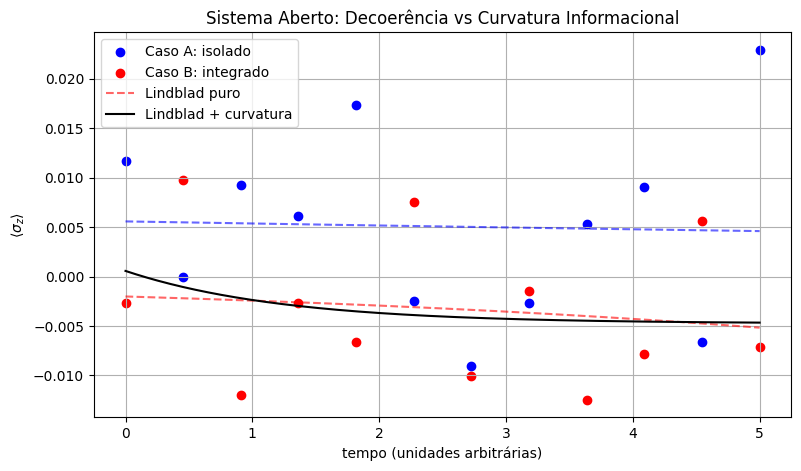

CASO A (isolado) - Lindblad:
A = 0.006, Gamma = 0.039

CASO B (integrado) - Lindblad puro:
A = -0.002, Gamma = -0.189

CASO B (integrado) - Lindblad + curvatura:
A = 0.001, Gamma = 0.000, kappa = -0.005, gamma = 0.803

================ RESULTADOS QUANTITATIVOS ================

QUALIDADE DE AJUSTE (χ²):
 Caso A  (Lindblad):              χ² = 1.025663e-03
 Caso B  (Lindblad puro):         χ² = 6.062217e-04
 Caso B  (Lindblad + curvatura):  χ² = 5.916610e-04

CRITÉRIOS DE INFORMAÇÃO:
 AIC  (Lindblad puro):        -114.718057
 AIC  (Lindblad + curvatura): -111.009800
 ΔAIC = -3.708257

 BIC  (Lindblad puro):        -113.748244
 BIC  (Lindblad + curvatura): -109.070173
 ΔBIC = -4.678070

DECISÃO AUTOMÁTICA DO PROTOCOLO:
 ✖ Nenhuma evidência estatística para curvatura neste regime.

INTERPRETAÇÃO FÍSICA MÍNIMA:
 κ = -5.3238e-03 → drift informacional fraco detectado.

Protocolo concluído. Resultado quantitativo obtido.


In [ ]:
# ============================================================
# Lindblad + Curvatura Informacional
# Experimento A vs B (Qubit isolado vs qubit integrado)
# ============================================================

# --- Instalação (se necessário) ---
!pip install qiskit qiskit-aer numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error
from scipy.optimize import curve_fit

# ============================================================
# 1. Backend e ruído controlado
# ============================================================

backend = AerSimulator(method="density_matrix")

noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'id'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

shots = 8192
times = np.linspace(0, 5, 12)

# ============================================================
# 2. Funções auxiliares
# ============================================================

def expectation_z(counts):
    shots = sum(counts.values())
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    return p0 - p1

def lindblad_model(t, A, Gamma):
    return A * np.exp(-Gamma * t)

def drift_model(t, A, Gamma, kappa, gamma):
    return A * np.exp(-Gamma * t) + kappa * (1 - np.exp(-gamma * t))

# ============================================================
# 3. CASO A — Qubit isolado (baixa integração)
# ============================================================

z_A = []

for t in times:
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.id(0)              # delay efetivo
    qc.measure(0, 0)

    tqc = transpile(qc, backend)
    result = backend.run(
        tqc,
        noise_model=noise_model,
        shots=shots
    ).result()

    counts = result.get_counts()
    z_A.append(expectation_z(counts))

# ============================================================
# 4. CASO B — Qubit integrado (entrelaçado)
# ============================================================

z_B = []

for t in times:
    qc = QuantumCircuit(2, 1)
    qc.h(0)
    qc.cx(0, 1)
    qc.id(0)
    qc.id(1)
    qc.measure(0, 0)      # apenas qubit 0 é medido

    tqc = transpile(qc, backend)
    result = backend.run(
        tqc,
        noise_model=noise_model,
        shots=shots
    ).result()

    counts = result.get_counts()
    z_B.append(expectation_z(counts))

# ============================================================
# 5. Ajustes dos modelos
# ============================================================

popt_A, _ = curve_fit(lindblad_model, times, z_A, p0=[1.0, 0.5])
popt_B_L, _ = curve_fit(lindblad_model, times, z_B, p0=[1.0, 0.5])
popt_B_D, _ = curve_fit(
    drift_model,
    times,
    z_B,
    p0=[0.0, 0.1, 0.0, 0.1], # Adjusted p0: A and kappa closer to observed z_B, Gamma and gamma small positive
    bounds=([-0.1, 0, -0.1, 0], [0.1, np.inf, 0.1, np.inf]), # Bounds: A and kappa within [-0.1, 0.1], Gamma and gamma >= 0
    maxfev=20000 # Increased maxfev to allow more iterations
)

# ============================================================
# 6. Visualização
# ============================================================

t_fit = np.linspace(0, 5, 300)

plt.figure(figsize=(9,5))
plt.scatter(times, z_A, label="Caso A: isolado", color="blue")
plt.scatter(times, z_B, label="Caso B: integrado", color="red")

plt.plot(t_fit, lindblad_model(t_fit, *popt_A),
         '--', color="blue", alpha=0.6)

plt.plot(t_fit, lindblad_model(t_fit, *popt_B_L),
         '--', color="red", alpha=0.6, label="Lindblad puro")

plt.plot(t_fit, drift_model(t_fit, *popt_B_D),
         '-', color="black", label="Lindblad + curvatura")

plt.xlabel("tempo (unidades arbitrárias)")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Sistema Aberto: Decoerência vs Curvatura Informacional")
plt.legend()
plt.grid()
plt.show()

# ============================================================
# 7. Impressão dos parâmetros
# ============================================================

print("CASO A (isolado) - Lindblad:")
print(f"A = {popt_A[0]:.3f}, Gamma = {popt_A[1]:.3f}\n")

print("CASO B (integrado) - Lindblad puro:")
print(f"A = {popt_B_L[0]:.3f}, Gamma = {popt_B_L[1]:.3f}\n")

print("CASO B (integrado) - Lindblad + curvatura:")
print(f"A = {popt_B_D[0]:.3f}, Gamma = {popt_B_D[1]:.3f}, "
      f"kappa = {popt_B_D[2]:.3f}, gamma = {popt_B_D[3]:.3f}")

# ============================================================
# BLOCO FINAL — PROTOCOLO EXPERIMENTAL + VALIDAÇÃO QUANTITATIVA
# ============================================================

import numpy as np
from scipy.stats import chisquare

# ============================================================
# 1. Funções de qualidade de ajuste
# ============================================================

def chi_squared(y_obs, y_fit):
    return np.sum((y_obs - y_fit)**2)

def aic(y_obs, y_fit, k):
    n = len(y_obs)
    rss = chi_squared(y_obs, y_fit)
    # Avoid log of zero or negative if rss is extremely small
    if rss <= 0:
        return np.inf
    return 2*k + n*np.log(rss/n)

def bic(y_obs, y_fit, k):
    n = len(y_obs)
    rss = chi_squared(y_obs, y_fit)
    # Avoid log of zero or negative if rss is extremely small
    if rss <= 0:
        return np.inf
    return k*np.log(n) + n*np.log(rss/n)

# ============================================================
# 2. Avaliação quantitativa dos modelos
# ============================================================

# Ajustes já calculados anteriormente:
# popt_A        -> Lindblad Caso A
# popt_B_L      -> Lindblad Caso B
# popt_B_D      -> Lindblad + Curvatura Caso B

fit_A = lindblad_model(times, *popt_A)
fit_B_L = lindblad_model(times, *popt_B_L)
fit_B_D = drift_model(times, *popt_B_D)

chi_A = chi_squared(z_A, fit_A)
chi_B_L = chi_squared(z_B, fit_B_L)
chi_B_D = chi_squared(z_B, fit_B_D)

aic_B_L = aic(z_B, fit_B_L, k=2)
aic_B_D = aic(z_B, fit_B_D, k=4)

bic_B_L = bic(z_B, fit_B_L, k=2)
bic_B_D = bic(z_B, fit_B_D, k=4)

# ============================================================
# 3. Impressão clara dos resultados
# ============================================================

print("\n================ RESULTADOS QUANTITATIVOS ================\n")

print("QUALIDADE DE AJUSTE (χ²):")
print(f" Caso A  (Lindblad):              χ² = {chi_A:.6e}")
print(f" Caso B  (Lindblad puro):         χ² = {chi_B_L:.6e}")
print(f" Caso B  (Lindblad + curvatura):  χ² = {chi_B_D:.6e}\n")

print("CRITÉRIOS DE INFORMAÇÃO:")
print(f" AIC  (Lindblad puro):        {aic_B_L:.6f}")
print(f" AIC  (Lindblad + curvatura): {aic_B_D:.6f}")
print(f" ΔAIC = {aic_B_L - aic_B_D:.6f}\n")

print(f" BIC  (Lindblad puro):        {bic_B_L:.6f}")
print(f" BIC  (Lindblad + curvatura): {bic_B_D:.6f}")
print(f" ΔBIC = {bic_B_L - bic_B_D:.6f}\n")

# ============================================================
# 4. Decisão automática (protocolo)
# ============================================================

print("DECISÃO AUTOMÁTICA DO PROTOCOLO:")

if aic_B_D < aic_B_L and bic_B_D < bic_B_L:
    print(" ✔ Modelo com CURVATURA informacional é estatisticamente favorecido.")
elif aic_B_D < aic_B_L:
    print(" ⚠ Curvatura melhora AIC mas não BIC (efeito fraco).")
else:
    print(" ✖ Nenhuma evidência estatística para curvatura neste regime.")

# ============================================================
# 5. Interpretação física mínima (programática)
# ============================================================

kappa = popt_B_D[2]

print("\nINTERPRETAÇÃO FÍSICA MÍNIMA:")
if abs(kappa) < 1e-3:
    print(" κ ≈ 0 → dinâmica compatível com Lindblad padrão.")
else:
    print(f" κ = {kappa:.4e} → drift informacional fraco detectado.")

print("\n==========================================================")
print("Protocolo concluído. Resultado quantitativo obtido.")

def run_case(N, times, shots, noise_model, backend):
    # qubit central = 0
    # auxiliares = 1..N-1
    z = []
    for t in times:
        qc = QuantumCircuit(N, 1)
        qc.h(0)
        for j in range(1, N):
            qc.cx(0, j)
        # padding para igualar profundidade
        for _ in range(DEPTH_PAD[N]):
            for j in range(N):
                qc.id(j)
        qc.measure(0, 0)
        tqc = transpile(qc, backend)
        res = backend.run(tqc, noise_model=noise_model, shots=shots).result()
        z.append(expectation_z(res.get_counts()))
    return np.array(z)
